In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.special import ellipk as K1
from scipy.special import ellipe as K2 #Complete elliptic integral of the first kind

# CSV to Pandas

In [ ]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "data_corr_testing")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
datas= []
corrs= []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)

# Analytic Calculations

In [3]:
T_c_analytic = 2/np.log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model
ln_T_c_analytic = np.log(T_c_analytic)

def get_E_mean_analytic(T):
    """Calculate the mean energy for the 2D Ising model at temperature T."""
    assert (T >= 0).all(), "Temperature is negative"
    sinh_T = np.sinh(2/T)
    cosh_T = np.cosh(2/T)
    tanh_T = np.tanh(2/T)
    #kappa = 2*sinh_T/cosh_T**2
    kappa = 2*tanh_T/cosh_T #Numerically more stable?
    ellip_int = K1(kappa)
    return -2*tanh_T-(sinh_T**2-1)/(sinh_T*cosh_T)*(2/np.pi*ellip_int-1)

def get_M_abs_analytic(T,B=None): #Absolute value because of spontaneous symmetry breaking
    assert (T >= 0).all(), "Temperature is negative"
    if B is not None:
        assert (B == 0).all(), "Expression only valid for B = 0"
    M_abs_inner = 1-np.sinh(2/T)**-4
    M_abs = np.where(T>=T_c_analytic,0,np.sign(M_abs_inner)*np.abs(M_abs_inner)**(1/8)) #Note continuity at T = T_c_analytic
    return M_abs

def get_cV_analytic(T):
    assert (T >= 0).all(), "Temperature is negative"
    b = 2/T #Thermodynamic beta up to a multiplicative constant
    sinh_b = np.sinh(b)
    cosh_b = np.cosh(b)
    tanh_b = np.tanh(b)
    kappa_b = 2*tanh_b/cosh_b #Numerically more stable?
    K1_int = K1(kappa_b)
    K2_int = K2(kappa_b)
    K1_prime =  (K2_int/(1-kappa_b**2)-K1_int)/kappa_b 
    zero_term = sinh_b**-2
    first_term = -(sinh_b**-2+2*cosh_b**-2)*(2/np.pi)*K1_int
    second_term = 4/np.pi*(sinh_b**2-1)**2/(sinh_b*cosh_b**4)*K1_prime
    cV_analytic = -b**2/2 * (zero_term + first_term + second_term)
    return cV_analytic

def get_chi_analytic(T): #Need partial derivative of M with respect to B
    assert (T >= 0).all(), "Temperature is negative"
    return 0

# Fitting

In [4]:
#Models for fitting
def power_law_fit(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( t** crit_exp)

def hyperbola_exp_decay_fit(d, R_0, d_c, xi):
   return np.where(d>d_c,R_0 * np.exp(-d/xi),R_0*d_c/d* np.exp(-d_c/xi))   

#Returns bounds as formatted for curve_fit
#[(L1,U1),(L2,U2),...(LN,UN)] to ([L1,L2,...,LN],[U1,U2,...,UN])
def to_tuple(bounds: list):
  lower = [b[0] for b in bounds]
  upper = [b[1] for b in bounds]
  return (lower,upper)

In [5]:
def T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):
    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    
    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    if from_above: #Approach critical temperature from above
        T_filt = T[T >= T_c_analytic]
        X_mean_filt = X_mean[T >= T_c_analytic]
        X_std_filt = X_std[T >= T_c_analytic]                
    else: #Approach critical temperature from below
        T_filt = T[T <= T_c_analytic]
        X_mean_filt = X_mean[T <= T_c_analytic]
        X_std_filt = X_std[T <= T_c_analytic] 

    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)

    X_mean_filt_fit = power_law_fit(T_filt,*popt)      
    X_mean_filt_res = X_mean_filt - X_mean_filt_fit
    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt
    N_filt = len(X_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(X_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    if print_summary:
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")  

    return popt, pcov, X_mean_filt_norm_res   

In [ ]:
def fit(fitting_model, X, Y_mean, Y_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):
    if fitting_model is power_law_fit:
        bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp  
        param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    elif fitting_model is hyperbola_exp_decay_fit:
        bounds = to_tuple([(0, np.inf), (0, np.inf), (0, np.inf)])  #Bounds for R_0, d_c, xi
        param_ests = [1, 1, 1] #Initial values for R_0, d_c, xi
    
    if from_above: #Approach critical temperature from above
        T_filt = T[T >= T_c_analytic]
        X_mean_filt = X_mean[T >= T_c_analytic]
        X_std_filt = X_std[T >= T_c_analytic]                
    else: #Approach critical temperature from below
        T_filt = T[T <= T_c_analytic]
        X_mean_filt = X_mean[T <= T_c_analytic]
        X_std_filt = X_std[T <= T_c_analytic] 

    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)

    X_mean_filt_fit = power_law_fit(T_filt,*popt)      
    X_mean_filt_res = X_mean_filt - X_mean_filt_fit
    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt
    N_filt = len(X_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(X_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    if print_summary:
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")  

    return popt, pcov, X_mean_filt_norm_res   

# Single CSV Calculations and Plotting

## Single CSV Calculations

In [6]:
#Settings for the analysis
selected_trial = -1 #Particular trial to analyze (0-indexed)

#Extract data from pandas DataFrame
data_selected_trial = datas[selected_trial]
corr_selected_trial = corrs[selected_trial]
T, E_mean, E_std, M_mean, M_std= data_selected_trial.T.to_numpy()
corr_data = corr_selected_trial.T.to_numpy()
T_corr = corr_data[0]
assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
R_data = corr_data[1:]
R_mean_matrix, R_std_matrix = np.array([R_data[i] for i in range(0,len(R_data),2)]), np.array([R_data[i] for i in range(1,len(R_data),2)])

cV = np.square(E_std)/np.square(T) #In units where k_B = 1
chi = np.square(M_std)/T #In units where k_B = 1
#cV_mean will need to come from combined best estimate: average of cV over CSVs (weighted by cV itself because this is the best estimate for the error of each cV?)
#cV_std will need to come from the standard error of standard deviation
#Same for chi_mean, chi_std

#General calculations
N = len(T)
T_min, T_max = T.min(), T.max()
T_analytic = np.linspace(T_min, T_max, 1000)

#Logarithmic scale calculations
ln_T = np.log(T)
ln_T_analytic = np.linspace(np.log(T_min), np.log(T_max), 1000)
def get_ln_std(X_mean, X_std, use_asymetric_error=True):
    if use_asymetric_error: #Asymmetric error handling
        ln_X_std_lower = np.abs(np.log(X_mean-X_std)) 
        ln_X_std_upper = np.abs(np.log(X_mean+X_std))
        ln_X_std = [ln_X_std_lower, ln_X_std_upper] 
    else:
        ln_X_std = X_std / X_mean  # Propagated error (necessarily symmetric)
    return ln_X_std

In [7]:
def create_plot(X, X_symbol=r"?", X_name=r"???", X_c = None, X_c_symbol = None, Y_mean=None, Y_std=None, Y_symbol=r"?", Y_name=r"???", get_Y_analytic=None, log_plot = True, fitting_model=None, expected_crit_exp = 1.0, from_above=True):   
    #Error handling
    assert Y_mean is not None, "No vertical data given"
    if Y_std is None: #No error is given
        Y_std = np.zeros_like(Y_mean)
        with_errorbar = False
    else: #Check if error is identically 0
        with_errorbar = not (Y_std == np.zeros_like(Y_std)).all() 
    if not with_errorbar:
        print("*Proceeding assuming no error (unphysical)")
    if X_c_symbol is None:
        X_c_symbol = X_symbol

    if fitting_model is not None: #Work in progress: need to be careful with signs 
        pass         
        #popt, pcov, Y_mean_fit_norm_res=  fit(Y_mean, X_std, expected_crit_exp=expected_crit_exp, from_above=from_above)          
             
    if get_Y_analytic is not None: #If present, evaluate the analytic model for plotting if present
        X_min, X_max = np.min(X), np.max(X)
        X_analytic = np.linspace(X_min, X_max, 1000)
        Y_mean_analytic = get_Y_analytic(X_analytic) #T_analytic is of high spatial frequency to produce a smooth curve 
    else:
        Y_mean_analytic = None
        X_analytic = None

    if log_plot: #Calculations specific and plotting labels specific to using log plot
        ln_X = np.log(X)
        if X_c is not None:
            ln_X_c = np.log(X_c)
        ln_Y_mean = np.log(Y_mean)
        ln_Y_std = get_ln_std(Y_mean, Y_std)
        if get_Y_analytic is not None:                   
            ln_X_analytic = np.linspace(np.log(X_min), np.log(X_max), 1000)
            ln_Y_mean_analytic = np.log(get_Y_analytic(np.exp(ln_X_analytic)))
        else:
            ln_Y_mean_analytic = None
            ln_X_analytic = None
        using = [ln_X,ln_X_analytic,ln_X_c, ln_Y_mean, ln_Y_std, ln_Y_mean_analytic]
        X_label = f'$ln({X_symbol})$'
        Y_label = f'$ln({Y_symbol})$'
    else: #Calculations specific and plotting labels specific to non log plots     
        using = [X,X_analytic,X_c,Y_mean, Y_std, Y_mean_analytic] #No analytic curve for non-power-law fits
        X_label = f'${X_symbol}$'    
        Y_label = f'${Y_symbol}$'
    
    if get_Y_analytic is not None: #Calculations and plotting specific to having an analytic model
        #Residual calculations
        Y_mean_res_analytic = Y_mean - get_Y_analytic(X)
        Y_std_res_analytic = Y_std
        Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std
        Y_std_norm_res_analytic = 1 #Always 1 since X_std_norm_res_analytic = X_std_res_analytic / X_std = 1

        #Goodness of fit to analytic model
        degrees_of_freedom_analytic = N #Relies on global variable in cell above
        chi_squared_analytic= np.sum(np.square(Y_mean_norm_res_analytic)) 
        reduced_chi_squared_analytic = chi_squared_analytic / degrees_of_freedom_analytic     
        print(f"Reduced chi squared (analytic): {reduced_chi_squared_analytic}")

        #Plotting specific to having an analytic model
        fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
        ax, res_ax = axs[0], axs[1]                
        res_ax.errorbar(using[0], Y_mean_norm_res_analytic, yerr=Y_std_norm_res_analytic, fmt='o', color='blue', label='Residuals (analytic)')
        if X_c is not None:
            res_ax.axvline(x=using[2], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')      
        ax.plot(using[1], using[5], color='orange', label='Analytic')               
        res_ax.set_xlabel(X_label)
        res_ax.set_ylabel('Normalized Residual')
        res_ax.axhline(0, color='orange', linestyle='--')      
    else: #Plotting specific to not having residuals
        fig, ax = plt.subplots(1,1, constrained_layout=True)
        ax.set_xlabel(X_label)
    #Plotting common to all variants    
    if with_errorbar:
        ax.errorbar(x=using[0], y=using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    else:        
        ax.errorbar(x=using[0], y=using[3], fmt='o', yerr=None, color='blue', label='Simulated')
    ax.set_ylabel(Y_label)
    if X_c is not None:
        ax.axvline(x=using[2], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')        
    ax.legend()
    ax.set_title(f'{Y_name} vs {X_name}')
    plt.show()

In [ ]:
def create_T_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_fit, expected_crit_exp = 1.0, from_above=True):   
   create_plot(X=T, X_symbol=r"k_B T / J", X_name=r"Temperature", X_c = T_c_analytic, X_c_symbol="T", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)

In [ ]:
def create_d_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=hyperbola_exp_decay_fit, expected_crit_exp = 1.0, from_above=True):   
   create_plot(X=[i for i in range(1,len(mean)+1)], X_symbol=r"d", X_name=r"Offset", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)
   

## Single CSV Plots

In [10]:
create_T_plot(E_mean, E_std, symbol = 'E/J', name = 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic)

TypeError: create_plot() got an unexpected keyword argument 'perform_fit'

Reduced chi squared (analytic): 682.4147552095047


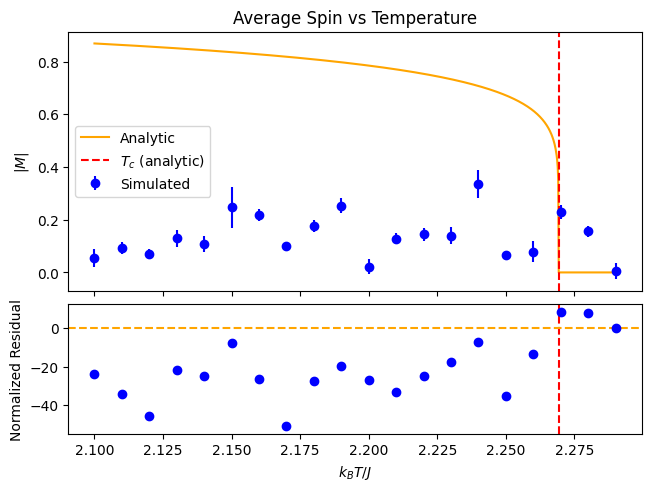

In [ ]:
create_T_plot(np.abs(M_mean), M_std, symbol='|M|', name='Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, perform_fit=False)

*Proceeding assuming no error (unphysical)
Reduced chi squared (analytic): inf


C:\Users\17757\AppData\Local\Temp\ipykernel_56108\1965767458.py:50: RuntimeWarning: divide by zero encountered in divide
  Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std


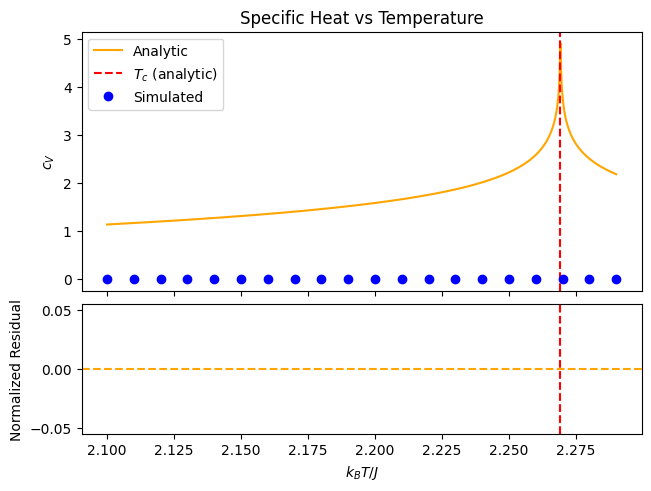

In [ ]:
create_T_plot(cV, symbol='c_V', name='Specific Heat', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

# Autocorrelation Single

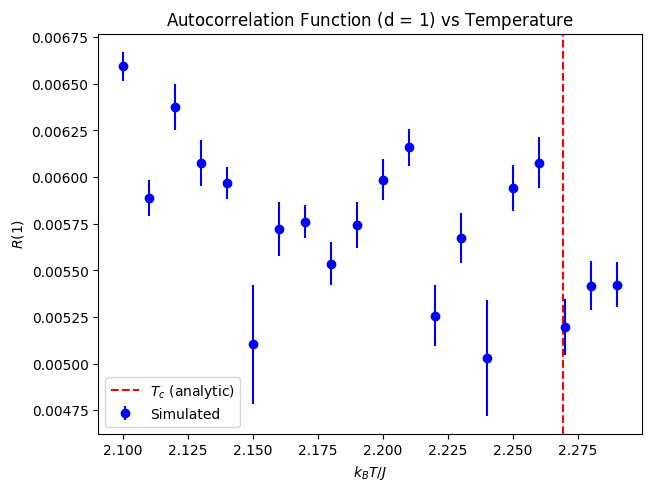

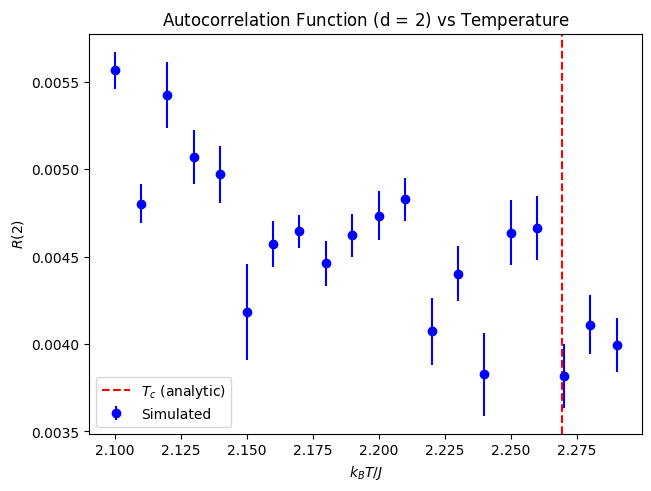

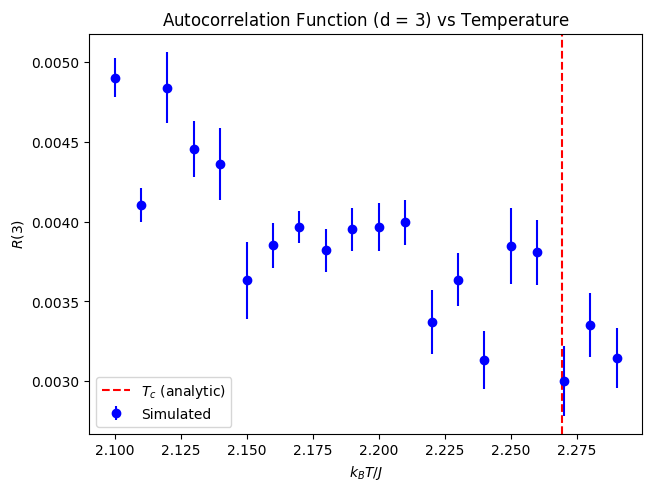

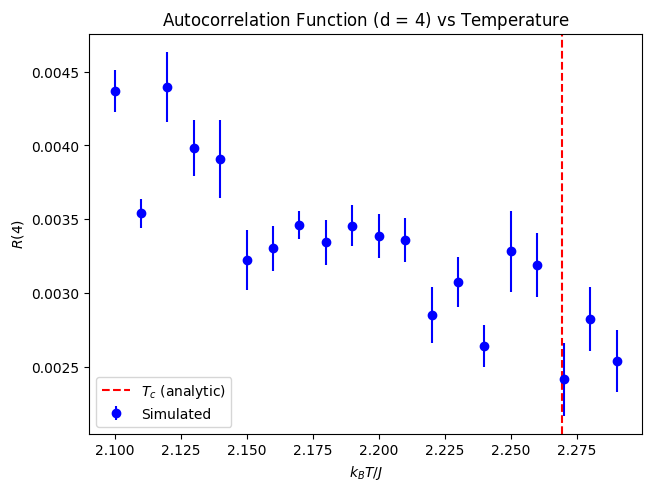

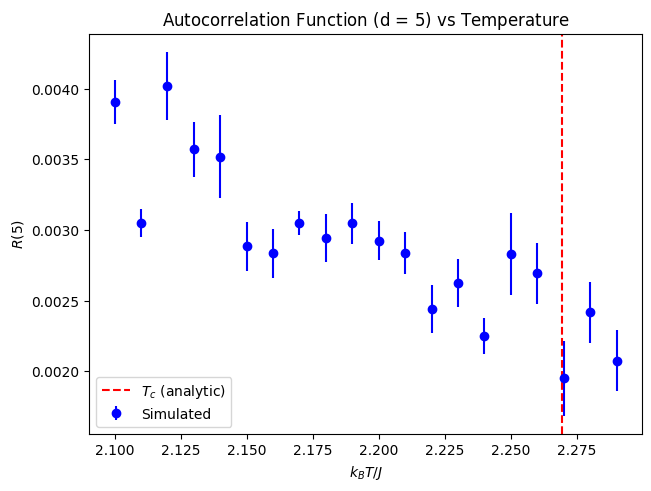

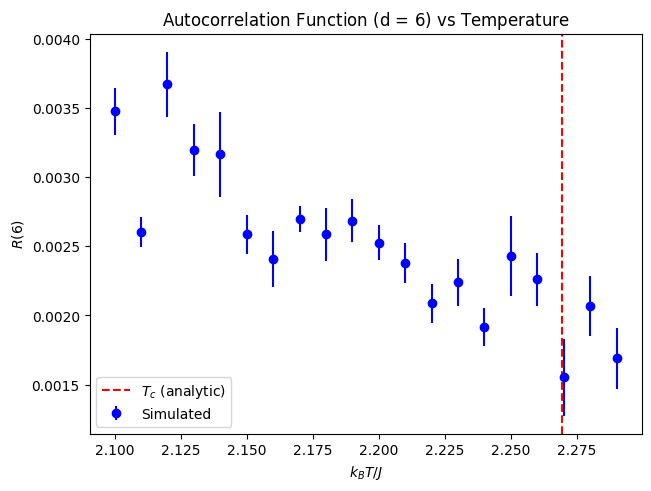

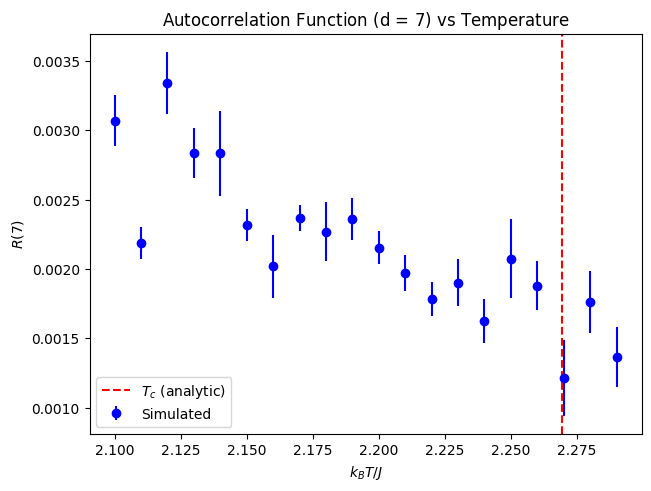

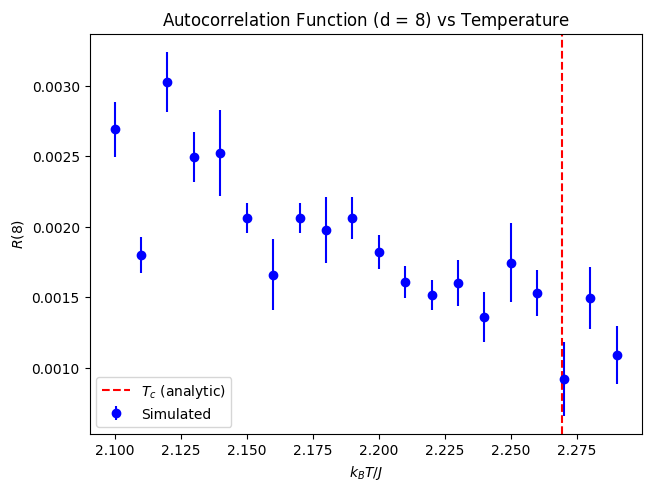

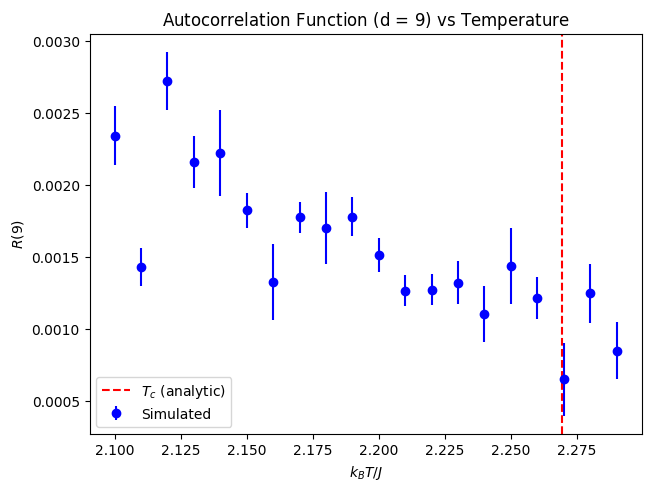

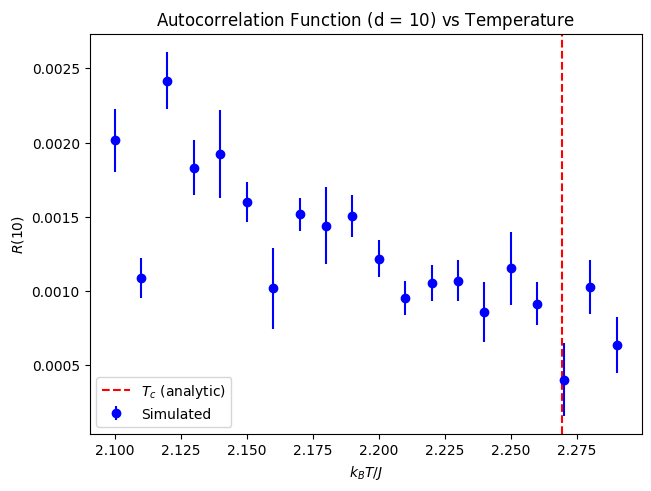

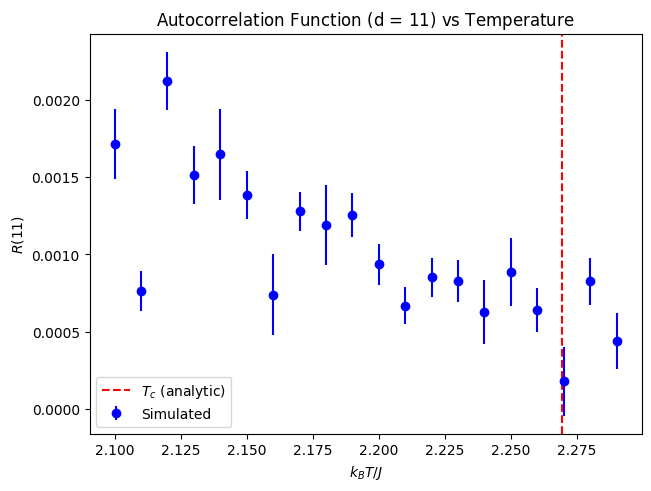

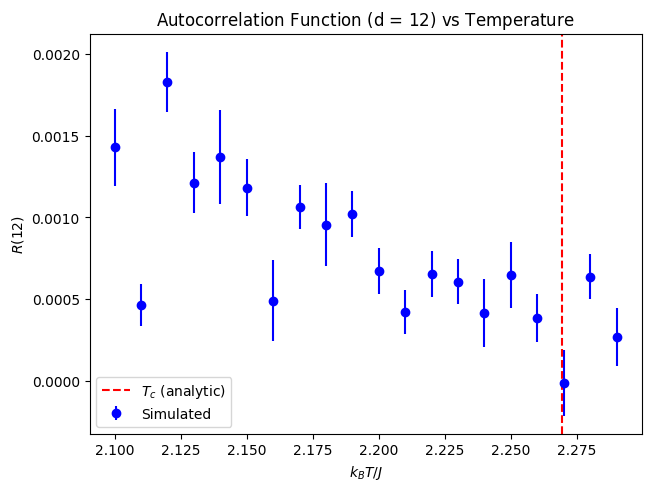

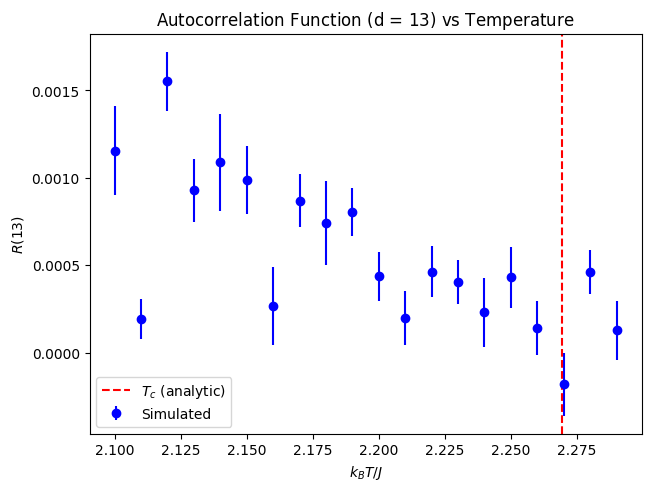

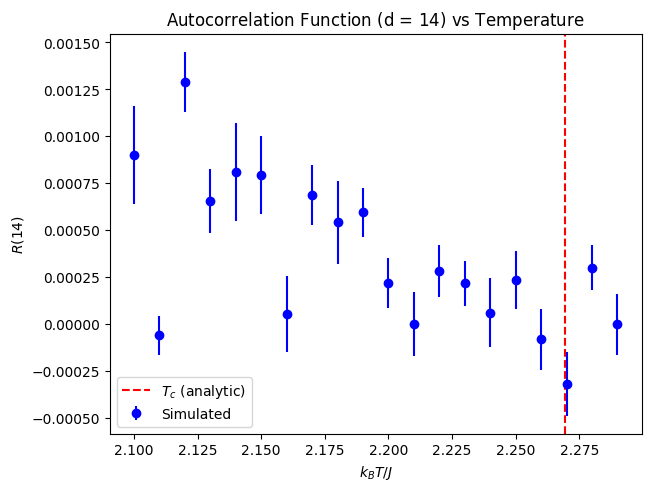

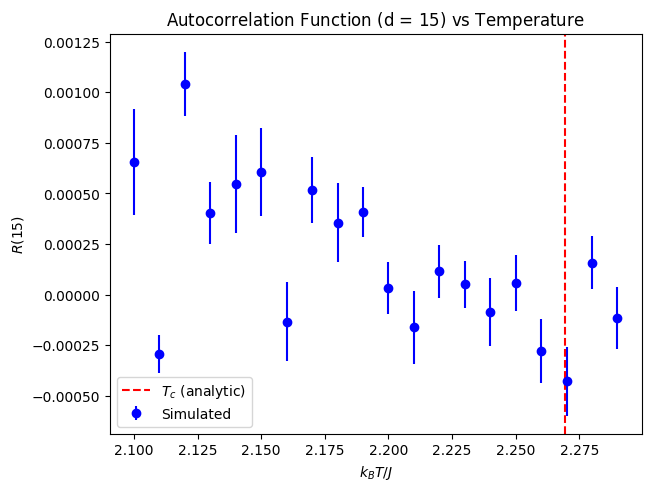

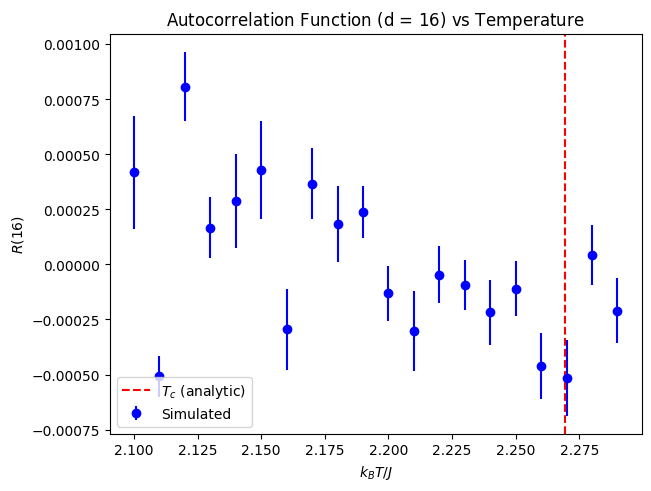

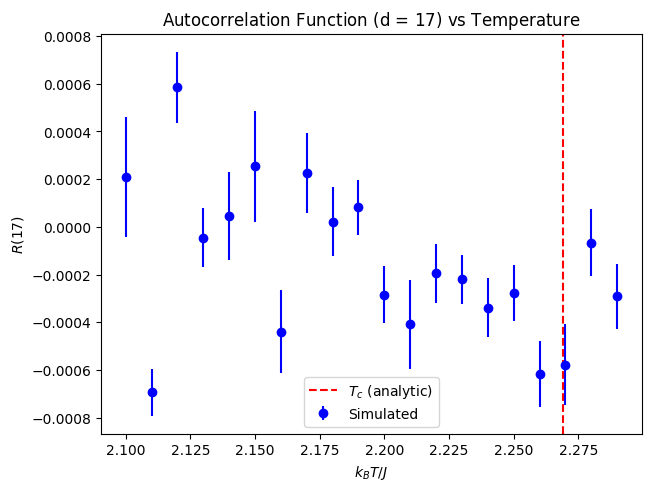

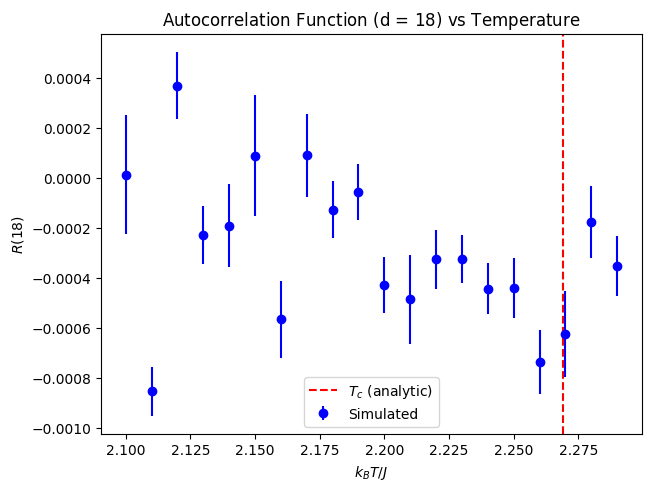

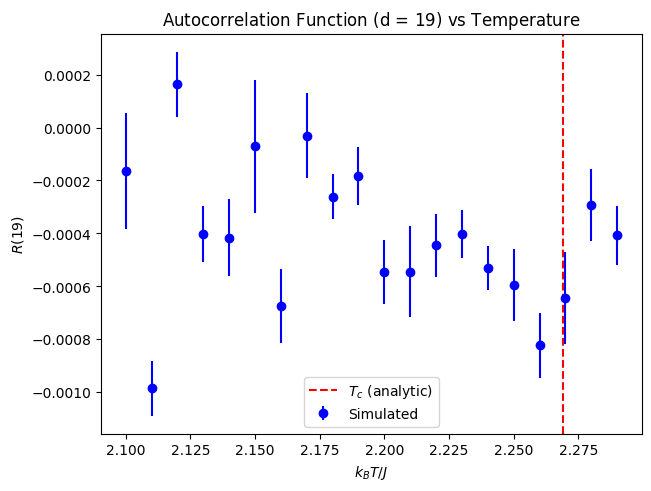

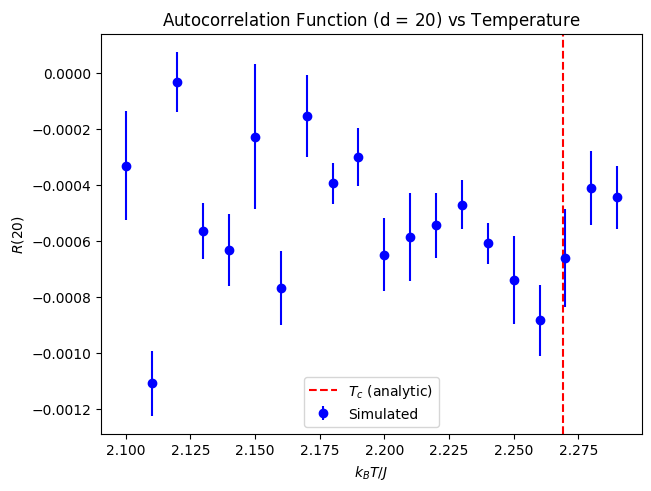

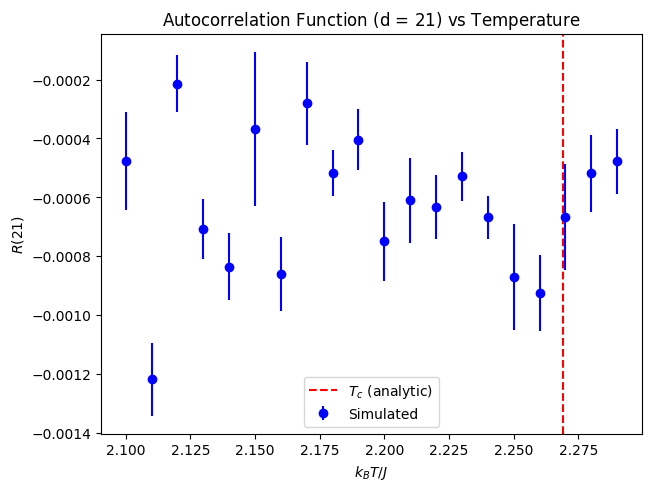

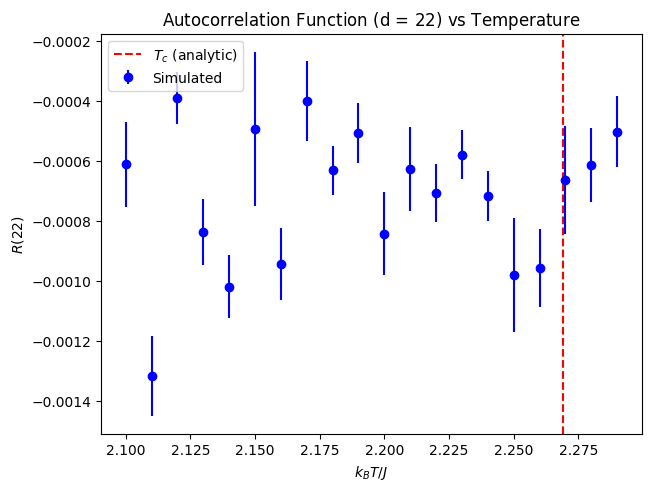

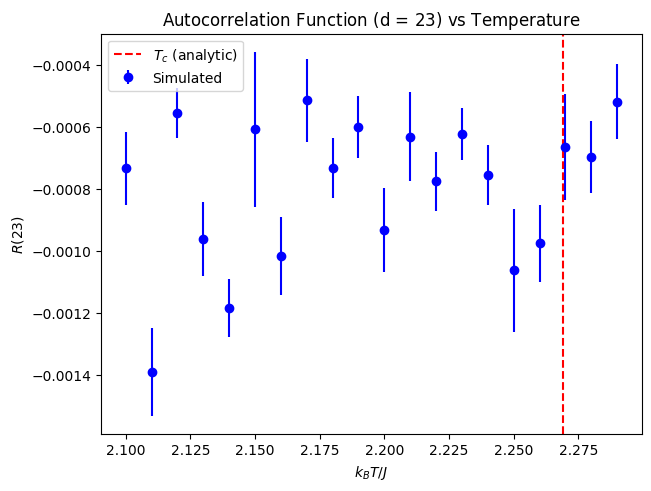

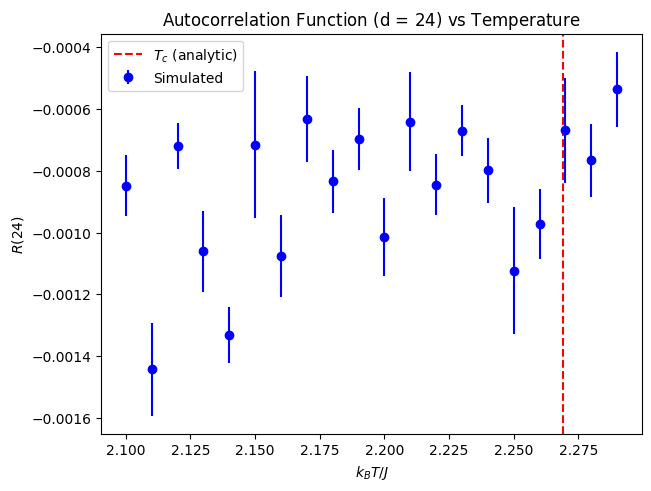

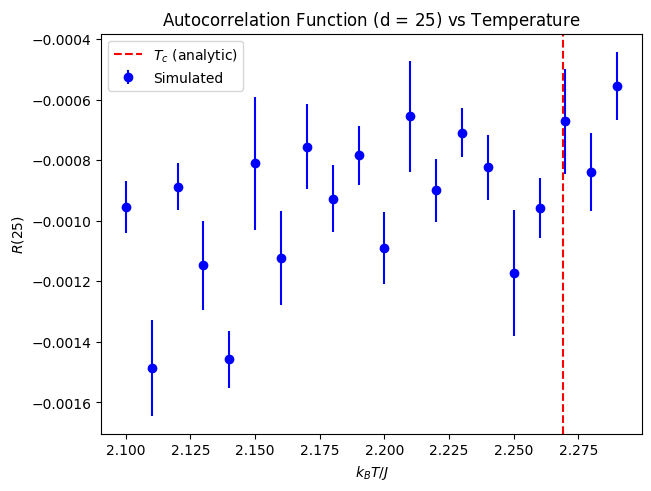

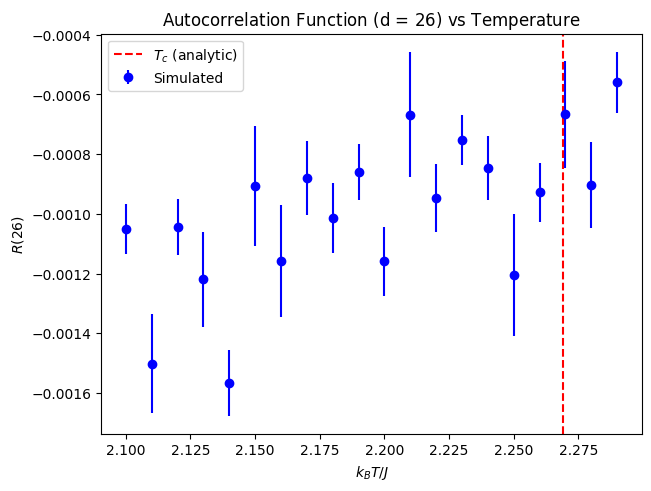

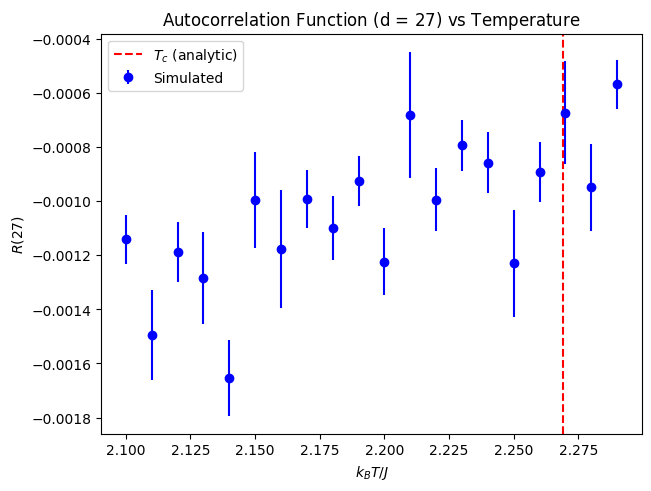

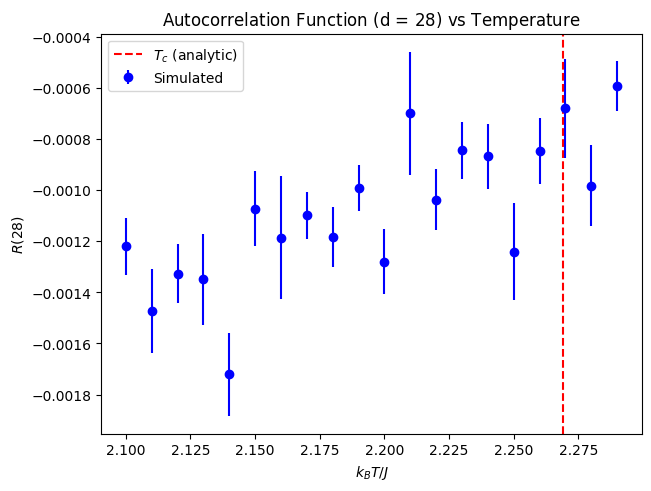

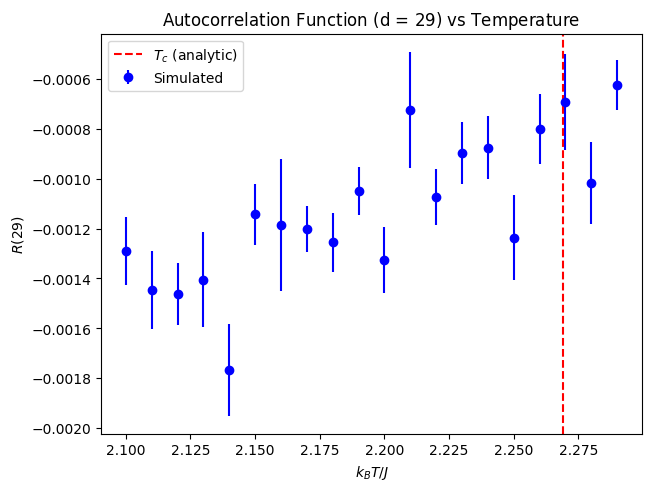

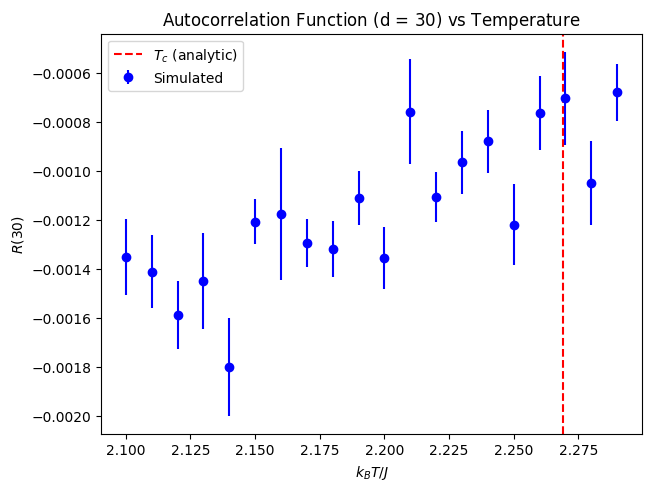

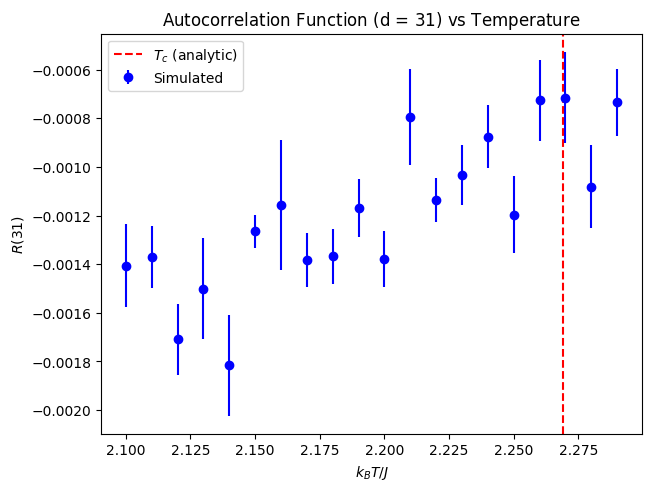

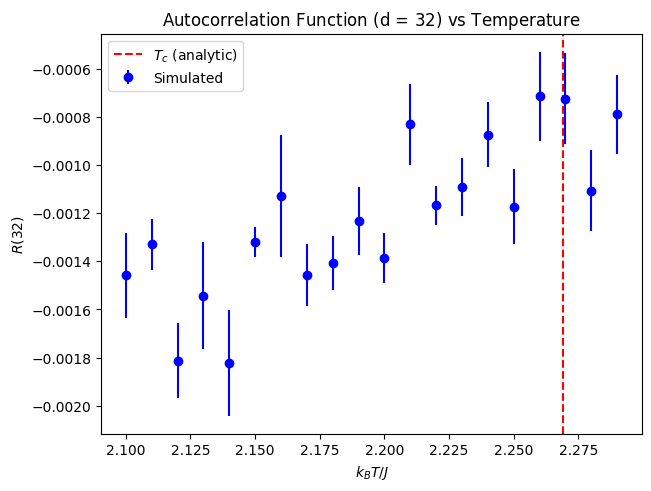

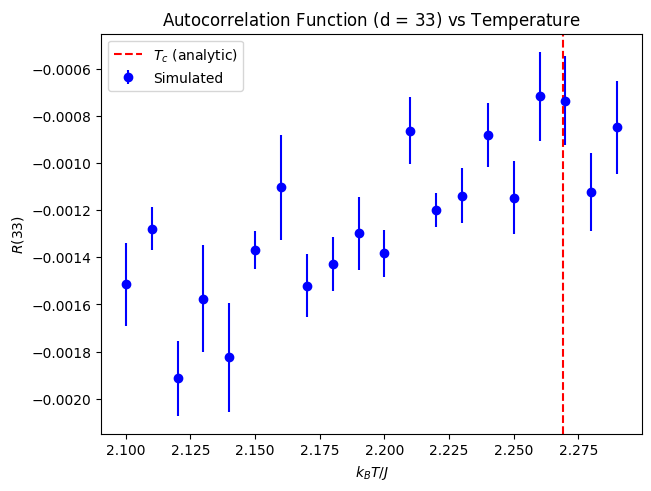

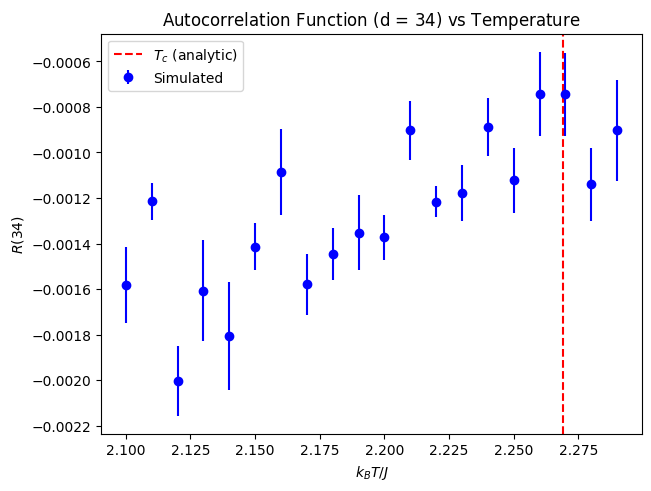

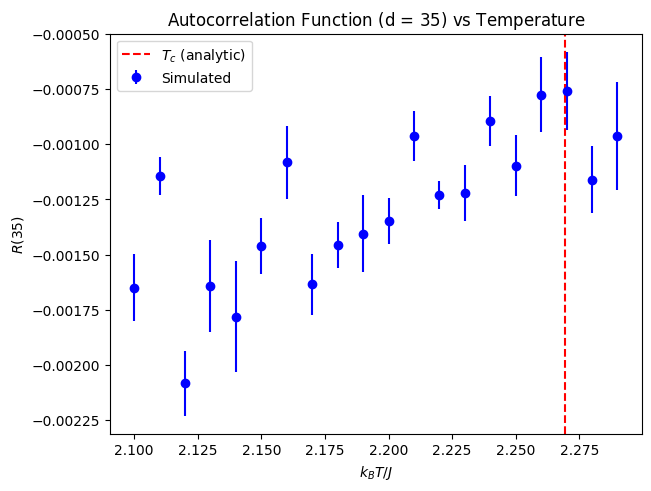

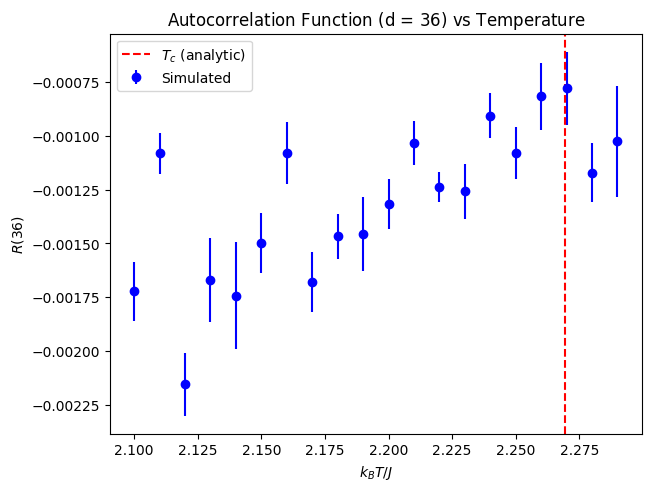

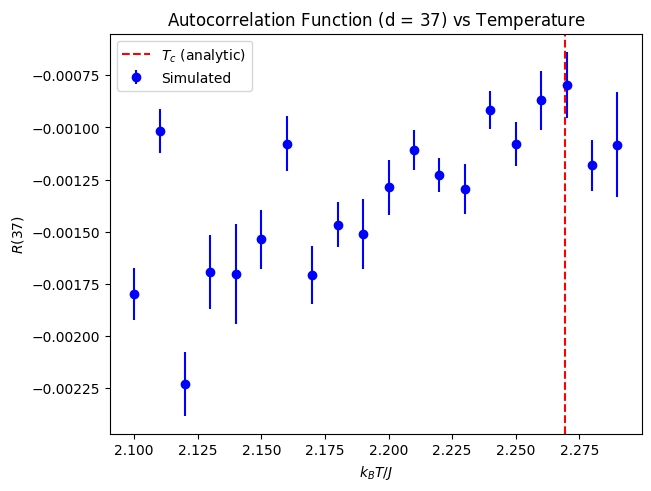

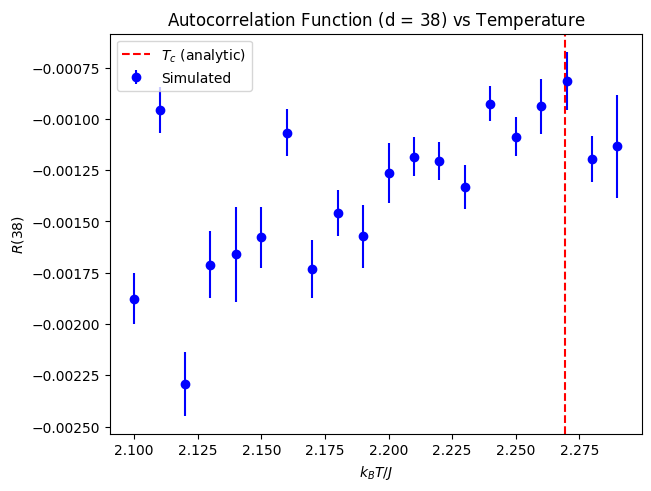

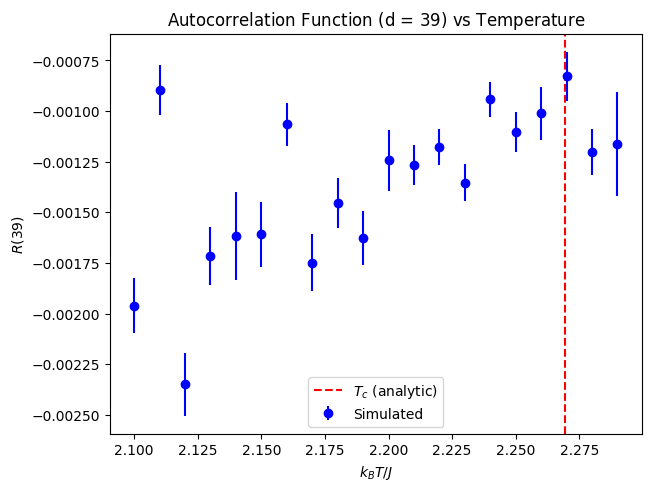

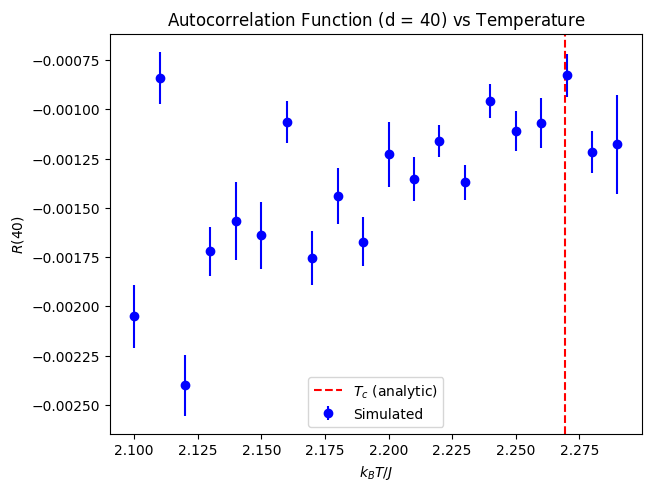

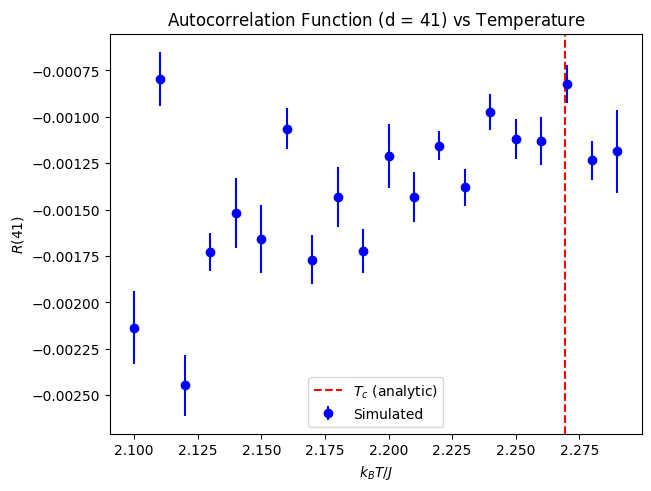

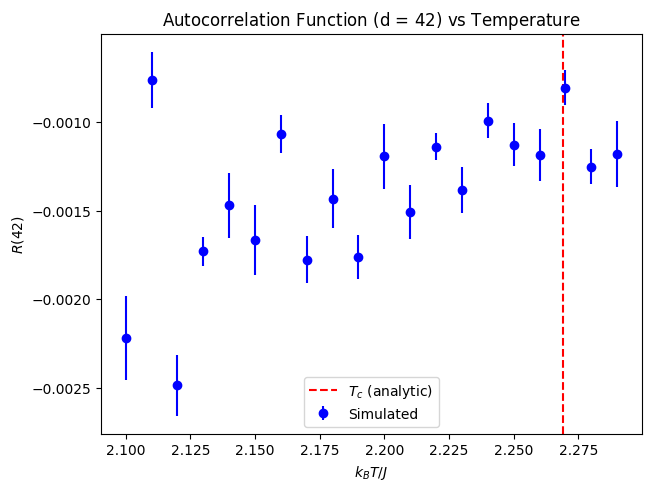

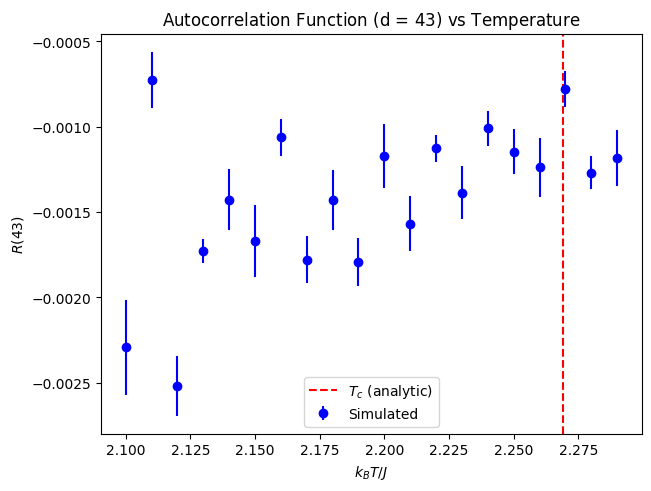

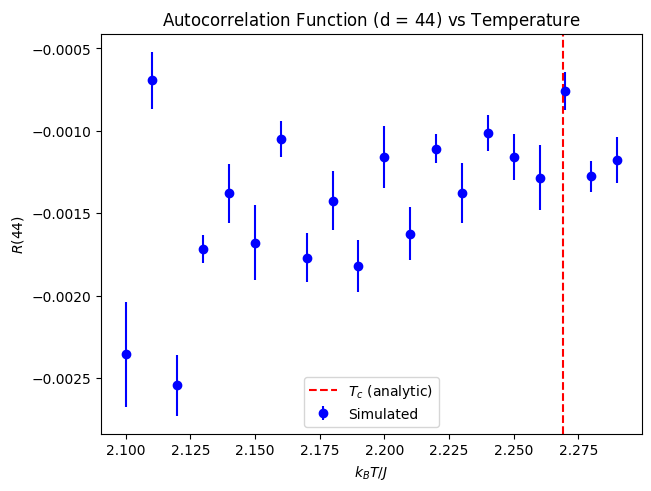

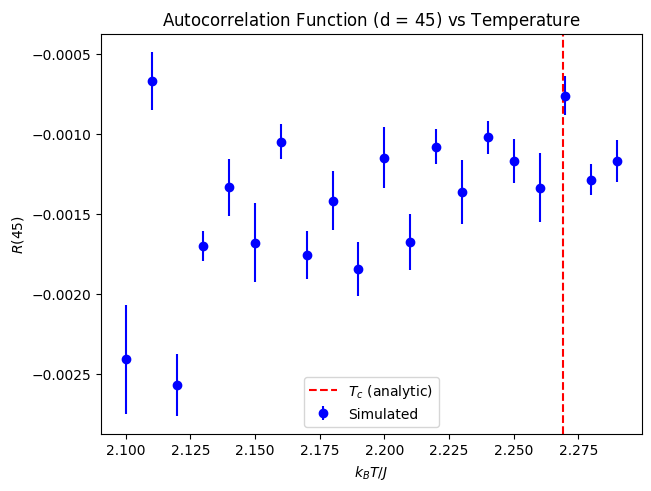

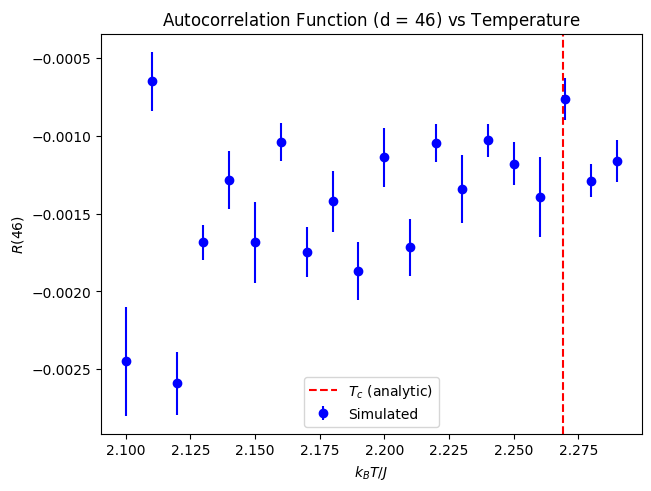

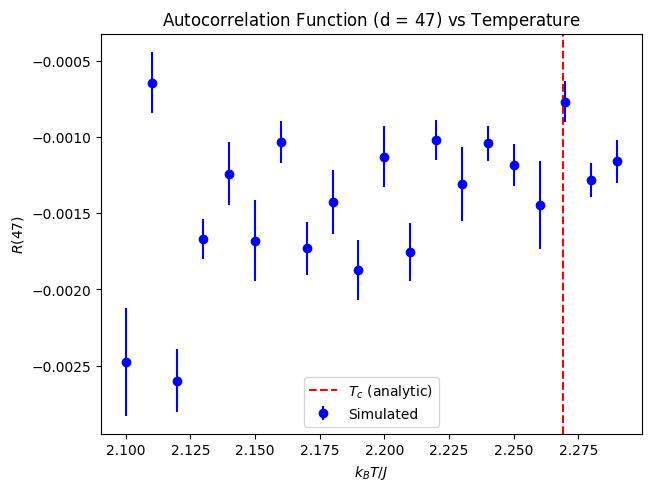

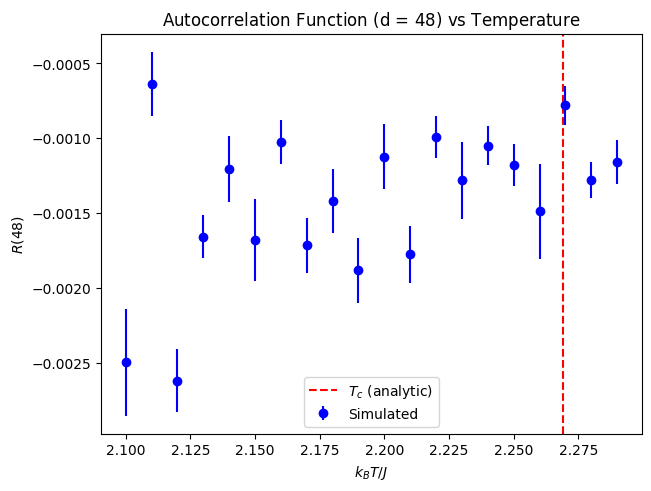

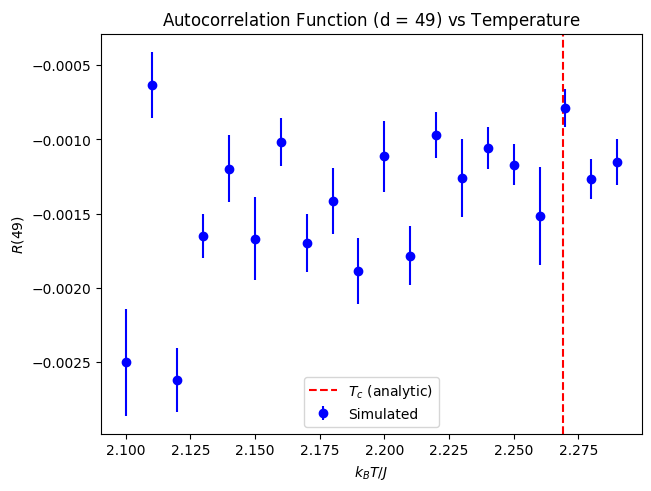

In [ ]:
for d, (R_mean, R_std) in enumerate(zip(R_mean_matrix, R_std_matrix), start=1):
    create_T_plot(mean=R_mean, std=R_std, symbol=f'R({d})', name=f'Autocorrelation Function (d = ${d}$)', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

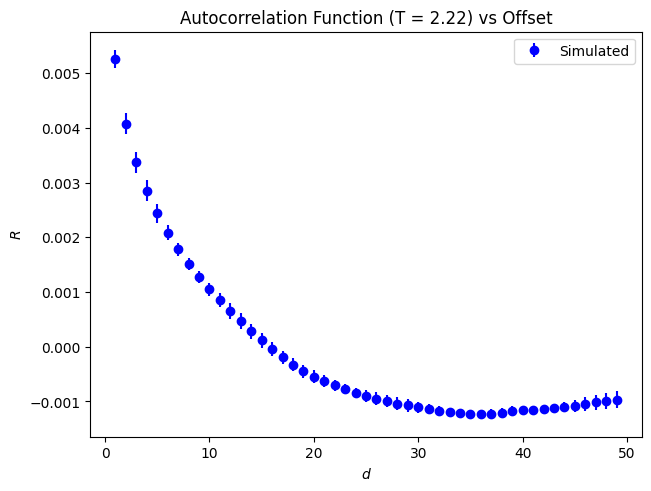

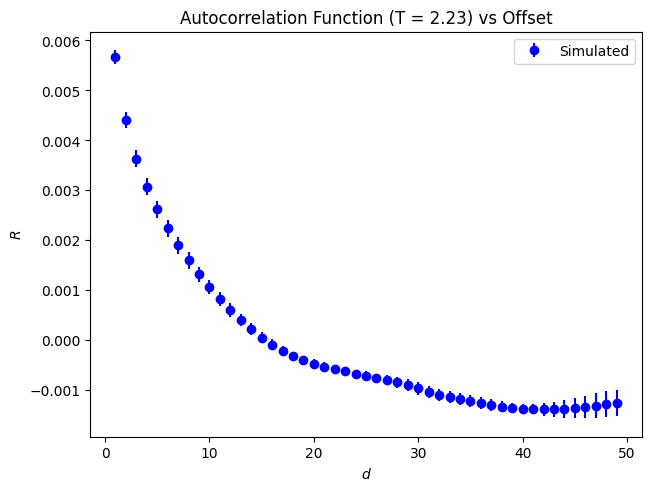

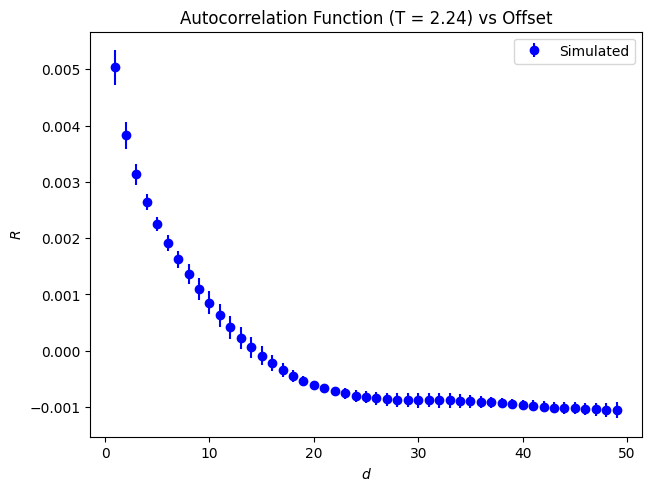

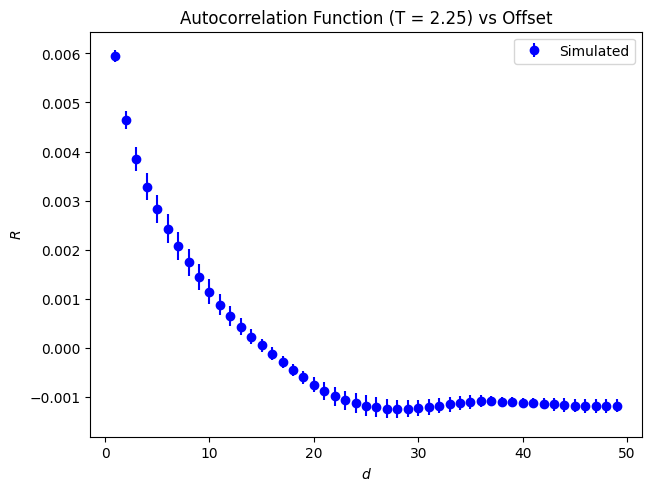

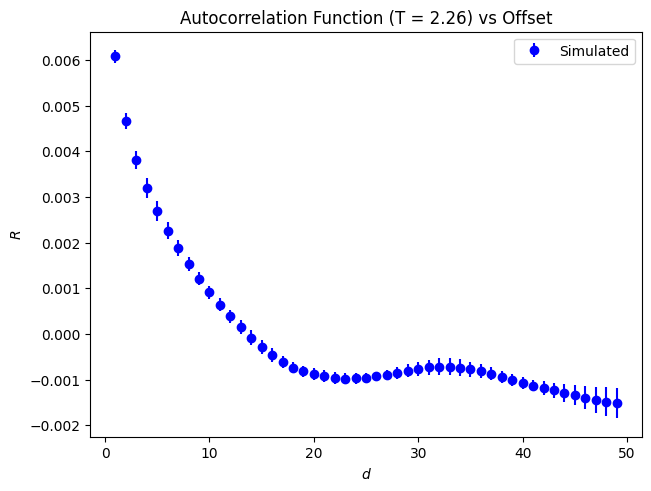

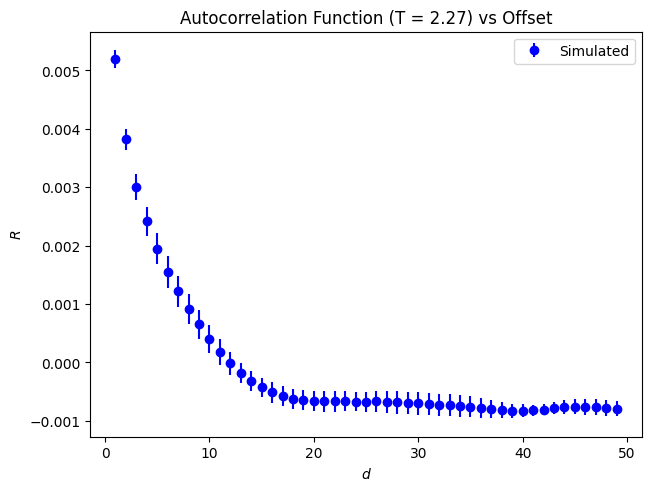

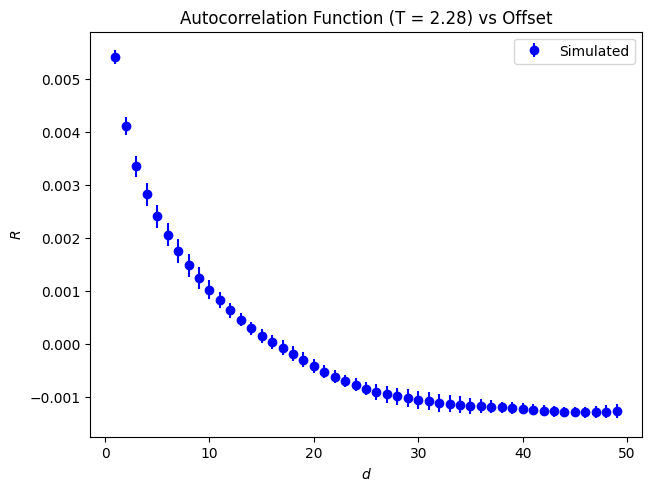

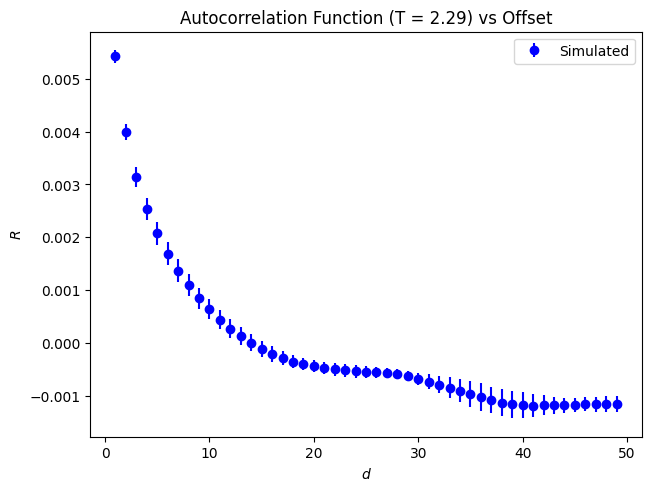

In [ ]:
for T_index, (R_mean, R_std) in enumerate(zip(R_mean_matrix.T, R_std_matrix.T)):
    T_current = T[T_index]
    if np.abs(T_current - T_c_analytic) < 0.5:
        create_d_plot(mean=R_mean, std=R_std, symbol='R', name= f'Autocorrelation Function (T = {T_current:.2f})', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

# Multiple CSV Calculations and Plotting

## Pandas to Numpy

In [ ]:
#All files in directory
E_means = []
E_stds = []
M_means = []
M_stds = []
R_means = []
R_stds = []
cVs = []
chis = []
for (data,corr) in zip(datas,corrs):
    T, E_mean, E_std, M_mean, M_std= data.T.to_numpy()
    corr_data = corr.T.to_numpy()
    T_corr = corr_data[0]
    assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
    R_data = corr_data[1:]
    R_mean, R_std = [R_data[i] for i in range(0,len(R_data),2)], [R_data[i] for i in range(1,len(R_data),2)]
    cV = np.square(E_std)/np.square(T) #In units where k_B = 1
    chi = np.square(M_std)/T #In units where k_B = 1
    E_means.append(E_mean)
    E_stds.append(E_std)
    M_means.append(M_mean)
    M_stds.append(M_std)
    R_means.append(R_mean)
    R_stds.append(R_std)
    cVs.append(cV)
    chis.append(chi)

E_weights = np.array(E_stds)**-2
E_est = np.average(E_means, axis=0, weights=E_weights)
E_est_std = 1/np.sqrt(np.sum(E_weights,axis=0))
M_weights = np.array(M_stds)**-2
M_est = np.average(M_means, axis=0, weights=M_weights)
M_est_std = 1/np.sqrt(np.sum(M_weights,axis=0))
M_abs_est = np.average(np.abs(M_means), axis=0, weights=M_weights)

R_weights = np.array(R_stds)**-2
R_est = np.average(R_means, axis=0, weights=R_weights)
R_est_std = 1/np.sqrt(np.sum(R_weights,axis=0))
cV_mean = np.mean(cVs, axis=0)
cV_std = np.std(cVs, axis=0)/np.sqrt(len(cVs)) #Standard error of the mean
chi_mean = np.mean(chis, axis=0)
chi_std = np.std(chis, axis=0)/np.sqrt(len(chis)) #Standard error of the mean

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

## Plotting

Reduced chi squared (analytic): 7.647032485243327


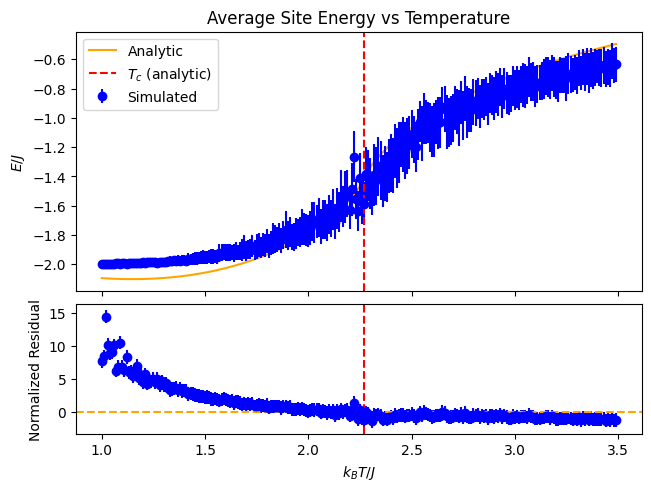

In [ ]:
create_T_plot(E_est, E_est_std, 'E/J', 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic)

Reduced chi squared (analytic): 2.45365802691475


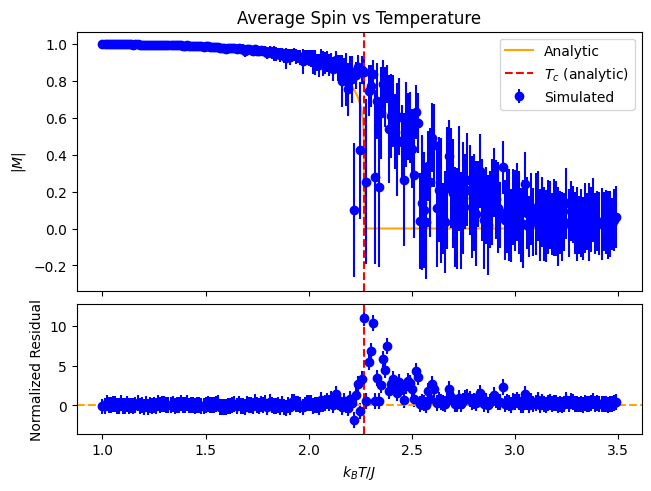

In [ ]:
create_T_plot(np.abs(M_abs_est), M_est_std, '|M|', 'Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, perform_fit=False)

In [ ]:
print(f"cV_mean: {cV_mean}")

cV_mean: [0.00037242 0.00028479 0.00014753 0.00018283 0.00025441 0.00022505
 0.00022009 0.00049497 0.00043816 0.00018208 0.00040278 0.0004722
 0.0002879  0.00052302 0.0004939  0.00066505 0.00051746 0.00042072
 0.00070032 0.00057746 0.00095074 0.00050006 0.0011386  0.0006819
 0.00079017 0.00062259 0.00083933 0.00070158 0.00098016 0.00077587
 0.000824   0.00077837 0.00106603 0.0013638  0.00108292 0.00112869
 0.00096028 0.00121116 0.00103211 0.00127659 0.00113937 0.00101445
 0.00166455 0.00144121 0.00149922 0.00173232 0.00165574 0.00170007
 0.00184596 0.00184233 0.0018624  0.00170808 0.00177422 0.00215841
 0.00229632 0.00175339 0.00188407 0.00339182 0.00268933 0.00251259
 0.00264554 0.00266923 0.0027226  0.00228747 0.00285037 0.0026623
 0.00214436 0.00292301 0.00410225 0.00468002 0.00308481 0.00276942
 0.0031762  0.00371106 0.0034387  0.00606209 0.00466021 0.0031683
 0.00384861 0.00407739 0.00427425 0.00400634 0.00409625 0.00776913
 0.00550494 0.00427708 0.0051137  0.00418807 0.00541637 0

Reduced chi squared (analytic): 982329656.3387115


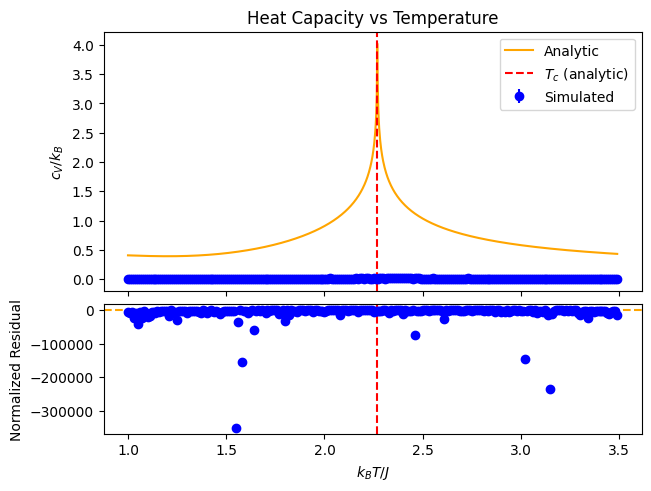

In [ ]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

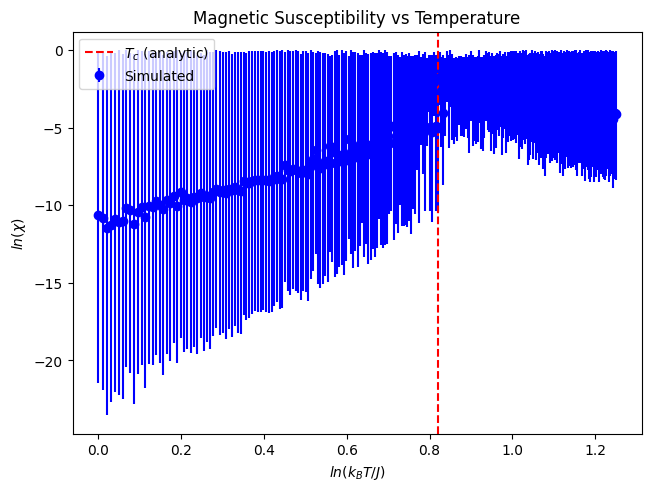

In [ ]:
create_T_plot(chi_mean, chi_std, symbol= r'\chi', name='Magnetic Susceptibility', log_plot = True, expected_crit_exp=-7/4) #zeros_like forces std to default which is then propagated for ln

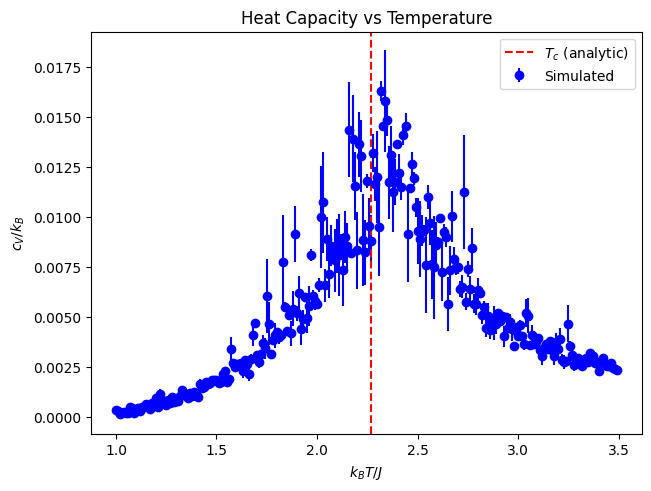

In [ ]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

## Analysis of Burn-In Time and Annealing
 n_transfer = 3000, inp['n_analyze']  = 5000, inp['n_burnin']   =  [0,100,200,300,400,500,600,700,10000]

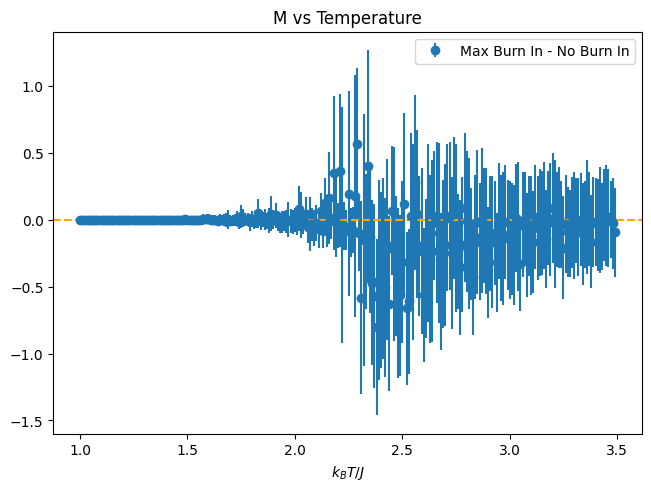

In [ ]:
fig, ax = plt.subplots(1,1, constrained_layout=True, sharex=True)
X_mean_first = np.abs(M_means[0])
X_std_first = M_stds[0]
X_mean_last = np.abs(M_means[-1])
X_std_last = M_stds[-1]
X_mean_diff = X_mean_last - X_mean_first
X_std_diff = np.sqrt(X_std_last**2 + X_std_first**2) #Assuming independent errors
ax.errorbar(x=T, y=X_mean_diff, yerr=X_std_diff, fmt='o', label='Max Burn In - No Burn In')
ax.axhline(0, color='orange', linestyle='--')
ax.set_xlabel('$k_BT / J$')
'''
res_ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')      
ax.plot(using[1], using[5], color='orange', label='Analytic')               
res_ax.set_xlabel(T_label)
res_ax.set_ylabel('Normalized Residual')
res_ax.axhline(0, color='orange', linestyle='--')      
else: #Plotting specific to not having residuals
    fig, ax = plt.subplots(1,1, constrained_layout=True)
    ax.set_xlabel(T_label)
#Plotting common to all variants    
if with_errorbar:
    ax.errorbar(using[0], using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    else:        
    ax.errorbar(using[0], using[3], fmt='o', yerr=None, color='blue', label='Simulated')
ax.set_ylabel(X_label)
ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')    
'''
ax.legend()
ax.set_title('M vs Temperature')
plt.show()